In [4]:
# STEP 1 Import Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# STEP 2 Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Projects/Amazon Fine Food Review/Reviews.csv')  # From Amazon Fine Food Reviews dataset
text_column = 'Text'

In [7]:
# STEP 3 Text Preprocessing Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    # Removed the second block of identical code
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Removed the line attempting to modify df inside the function
    return ' '.join(tokens)

In [8]:
# Install and import swifter for faster apply
try:
    import swifter
except ModuleNotFoundError:
    !pip install swifter
    import swifter

df['clean_text'] = df[text_column].astype(str).swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/568454 [00:00<?, ?it/s]

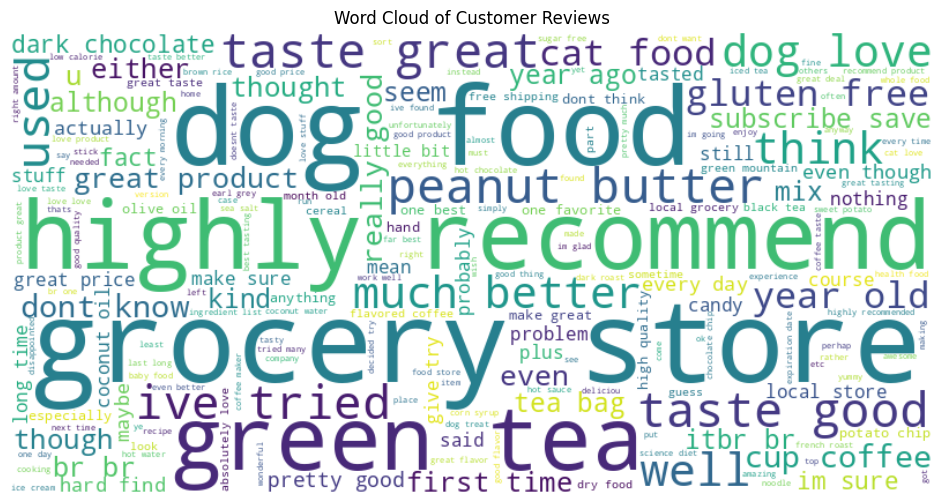

In [9]:
# STEP 4 Word Cloud for Visualization
text_blob = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Reviews')
plt.show()

In [10]:
# STEP 5 Topic Modeling with LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=10,                # skip rare words
    max_features=1000,        # cap vocabulary size
    stop_words='english'
)

X_counts = vectorizer.fit_transform(df['clean_text'])

In [13]:
import time
start = time.time()

# Initialize LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0) # You can adjust n_components as needed

lda = LatentDirichletAllocation(
    n_components=5,
    learning_method='online',  # faster, especially for large sparse data
    max_iter=5,                # default is 10; reduce if needed
    random_state=0
)

In [15]:
# Fit the LDA model to the data
lda.fit(X_counts)

def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx + 1}")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic #1
br taste like water sugar flavor use add product oil

Topic #2
product like chocolate taste good time box great really make

Topic #3
food dog treat cat br love like eat day product

Topic #4
coffee tea flavor cup like taste drink good br strong

Topic #5
great love amazon price store bag good chip flavor bar


In [19]:
# STEP 6 Sentiment Analysis (Simulated)
def label_sentiment(text):
    if any(word in text for word in ['good', 'great', 'love', 'excellent', 'awesome']):
        return 'positive'
    elif any(word in text for word in ['bad', 'poor', 'terrible', 'hate', 'worst']):
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text'].apply(label_sentiment)
print(df['sentiment'].value_counts())

sentiment
positive    358065
neutral     192331
negative     18058
Name: count, dtype: int64


In [21]:
# STEP 7 Train Classifier (Optional - if labeled data available)
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment'], test_size=0.2, random_state=42)
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# STEP 7 Train Classifier (Optional - if labeled data available)
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment'], test_size=0.2, random_state=42)
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report\n")
print(classification_report(y_test, y_pred))

Classification Report

              precision    recall  f1-score   support

    negative       0.57      0.00      0.00      3628
     neutral       0.97      0.09      0.16     38436
    positive       0.65      1.00      0.79     71627

    accuracy                           0.66    113691
   macro avg       0.73      0.36      0.32    113691
weighted avg       0.75      0.66      0.55    113691



In [24]:
from google.colab import files

# Save file
df.to_csv("nlp_analysis_output.csv", index=False)

# Trigger download to your computer
files.download("nlp_analysis_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>